# 📊 Visualização da Evolução de Grupos de Clientes (Anonimizado)

Este script utiliza **Plotly** para gerar gráficos interativos a partir de um DataFrame de classificações históricas de clientes.

---

## 🔹 DataFrame usado
- `df_results`: contém as classificações históricas por cliente,  
  com colunas `group_2021`, `group_2022`, `group_2023`, `group_2024` e `group_2025`.

---

## 🔹 O que o código faz
1. Extrai os grupos únicos de cada ano, removendo valores nulos e categorias como **"unclassified"**.  
2. Ordena os grupos de acordo com uma hierarquia definida (`hierarchy_order`) e adiciona os demais em ordem alfabética.  
3. Gera um conjunto de **subplots** (um gráfico de barras para cada grupo), mostrando a evolução de **2021 a 2025**.  
4. Cria uma **versão alternativa consolidada** com todos os grupos em um único gráfico de barras agrupadas.  
5. Exibe estatísticas simples, como:
   - ordem dos grupos
   - crescimento de cada grupo entre 2021 e 2025  

---

👉 Este script é apenas para **visualização**.  
A lógica de classificação (quem pertence a qual grupo) foi feita anteriormente e resultou no DataFrame `df_results`.


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

# Paleta de cores para diferentes grupos
color_palette = [
    '#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7',
    '#DDA0DD', '#98D8C8', '#F7DC6F', '#BB8FCE', '#85C1E9'
]

# DataFrame genérico com classificações (substitua pelo seu)
# Exemplo: df_results = classifier.generate_historical_classification(years)
df_results = pd.DataFrame()  # placeholder

# Obter a lista de grupos únicos (por ano)
groups_raw = pd.unique(df_results[['group_2021', 'group_2022',
                                   'group_2023', 'group_2024',
                                   'group_2025']].values.ravel())

# Remover valores NaN e "unclassified"
groups_filtered = [g for g in groups_raw if pd.notna(g) and str(g).lower() != 'unclassified']

# Definir ordem hierárquica desejada (exemplo fictício)
hierarchy_order = ['fans', 'premium', 'super vip', 'vip', 'gold', 'platinum', 'diamond']

# Ordenar grupos conforme hierarquia (case-insensitive)
groups = []
for level in hierarchy_order:
    for g in groups_filtered:
        if str(g).lower() == level.lower():
            groups.append(g)

# Adicionar grupos que não estão na hierarquia (ordenados alfabeticamente)
remaining_groups = [g for g in groups_filtered if str(g).lower() not in [n.lower() for n in hierarchy_order]]
groups.extend(sorted(remaining_groups, key=lambda x: str(x).lower()))

# Calcular número de subplots necessários
n_groups = len(groups)
cols = 2
rows = (n_groups + cols - 1) // cols

# Criar subplots
fig = make_subplots(
    rows=rows, cols=cols,
    subplot_titles=[f'Group: {g}' for g in groups],
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

# Loop para criar um gráfico por grupo
for i, g in enumerate(groups):
    if str(g).lower() == 'unclassified':
        continue

    counts = []
    for year in ['2021', '2022', '2023', '2024', '2025']:
        count = df_results[df_results[f'group_{year}'] == g].shape[0]
        counts.append({'Year': year, 'Quantity': count})

    df_group = pd.DataFrame(counts)

    row = i // cols + 1
    col = i % cols + 1

    base_color = color_palette[i % len(color_palette)]

    # Criar gradiente de cores
    colors = []
    for j in range(len(df_group)):
        hex_color = base_color.lstrip('#')
        r, g_c, b = tuple(int(hex_color[k:k+2], 16) for k in (0, 2, 4))
        intensity = 0.4 + (0.6 * j / (len(df_group) - 1)) if len(df_group) > 1 else 1.0
        colors.append(f'rgba({r}, {g_c}, {b}, {intensity})')

    fig.add_trace(
        go.Bar(
            x=df_group['Year'],
            y=df_group['Quantity'],
            name=f'Group {g}',
            marker=dict(
                color=colors,
                line=dict(color=base_color, width=2)
            ),
            showlegend=False,
            hovertemplate='<b>Year:</b> %{x}<br>' +
                         '<b>Quantity:</b> %{y}<br>' +
                         f'<b>Group:</b> {g}<extra></extra>'
        ),
        row=row, col=col
    )

# Layout
fig.update_layout(
    title={
        'text': '<b>Evolution of Groups by Year (2021-2025)</b>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 18, 'color': '#2C3E50'}
    },
    height=300 * rows,
    showlegend=False,
    plot_bgcolor='rgba(248,249,250,0.8)',
    paper_bgcolor='white',
    font=dict(family="Arial", size=12),
    margin=dict(t=80, b=50, l=50, r=50)
)

fig.update_xaxes(title_text="Year", tickangle=45, gridcolor='rgba(128,128,128,0.2)')
fig.update_yaxes(title_text="Number of Customers", gridcolor='rgba(128,128,128,0.2)')

fig.show()

# ======================================================
# Versão alternativa: todos os grupos em um único gráfico
# ======================================================
all_data = []
for g in groups:
    if str(g).lower() == 'unclassified':
        continue

    for year in ['2021', '2022', '2023', '2024', '2025']:
        count = df_results[df_results[f'group_{year}'] == g].shape[0]
        all_data.append({'Year': year, 'Quantity': count, 'Group': str(g)})

df_all = pd.DataFrame(all_data)

# Ordenar conforme hierarquia
def get_order_index(group_name):
    group_lower = str(group_name).lower()
    order_lower = [n.lower() for n in hierarchy_order]
    if group_lower in order_lower:
        return order_lower.index(group_lower)
    else:
        return len(hierarchy_order) + ord(group_lower[0]) if group_lower else 999

df_all['order'] = df_all['Group'].apply(get_order_index)
df_all = df_all.sort_values('order').drop('order', axis=1)

fig2 = px.bar(
    df_all,
    x='Year',
    y='Quantity',
    color='Group',
    title='<b>Comparison of All Groups (2021-2025)</b>',
    labels={'Quantity': 'Number of Customers', 'Year': 'Year'},
    color_discrete_sequence=color_palette[:len(df_all['Group'].unique())],
    barmode='group',
    category_orders={'Group': [str(c) for c in groups if str(c).lower() != 'unclassified']}
)

fig2.update_layout(
    title_x=0.5,
    plot_bgcolor='rgba(248,249,250,0.8)',
    paper_bgcolor='white',
    font=dict(family="Arial", size=12),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    height=500
)

fig2.update_xaxes(tickangle=45)
fig2.update_yaxes(gridcolor='rgba(128,128,128,0.2)')

fig2.show()


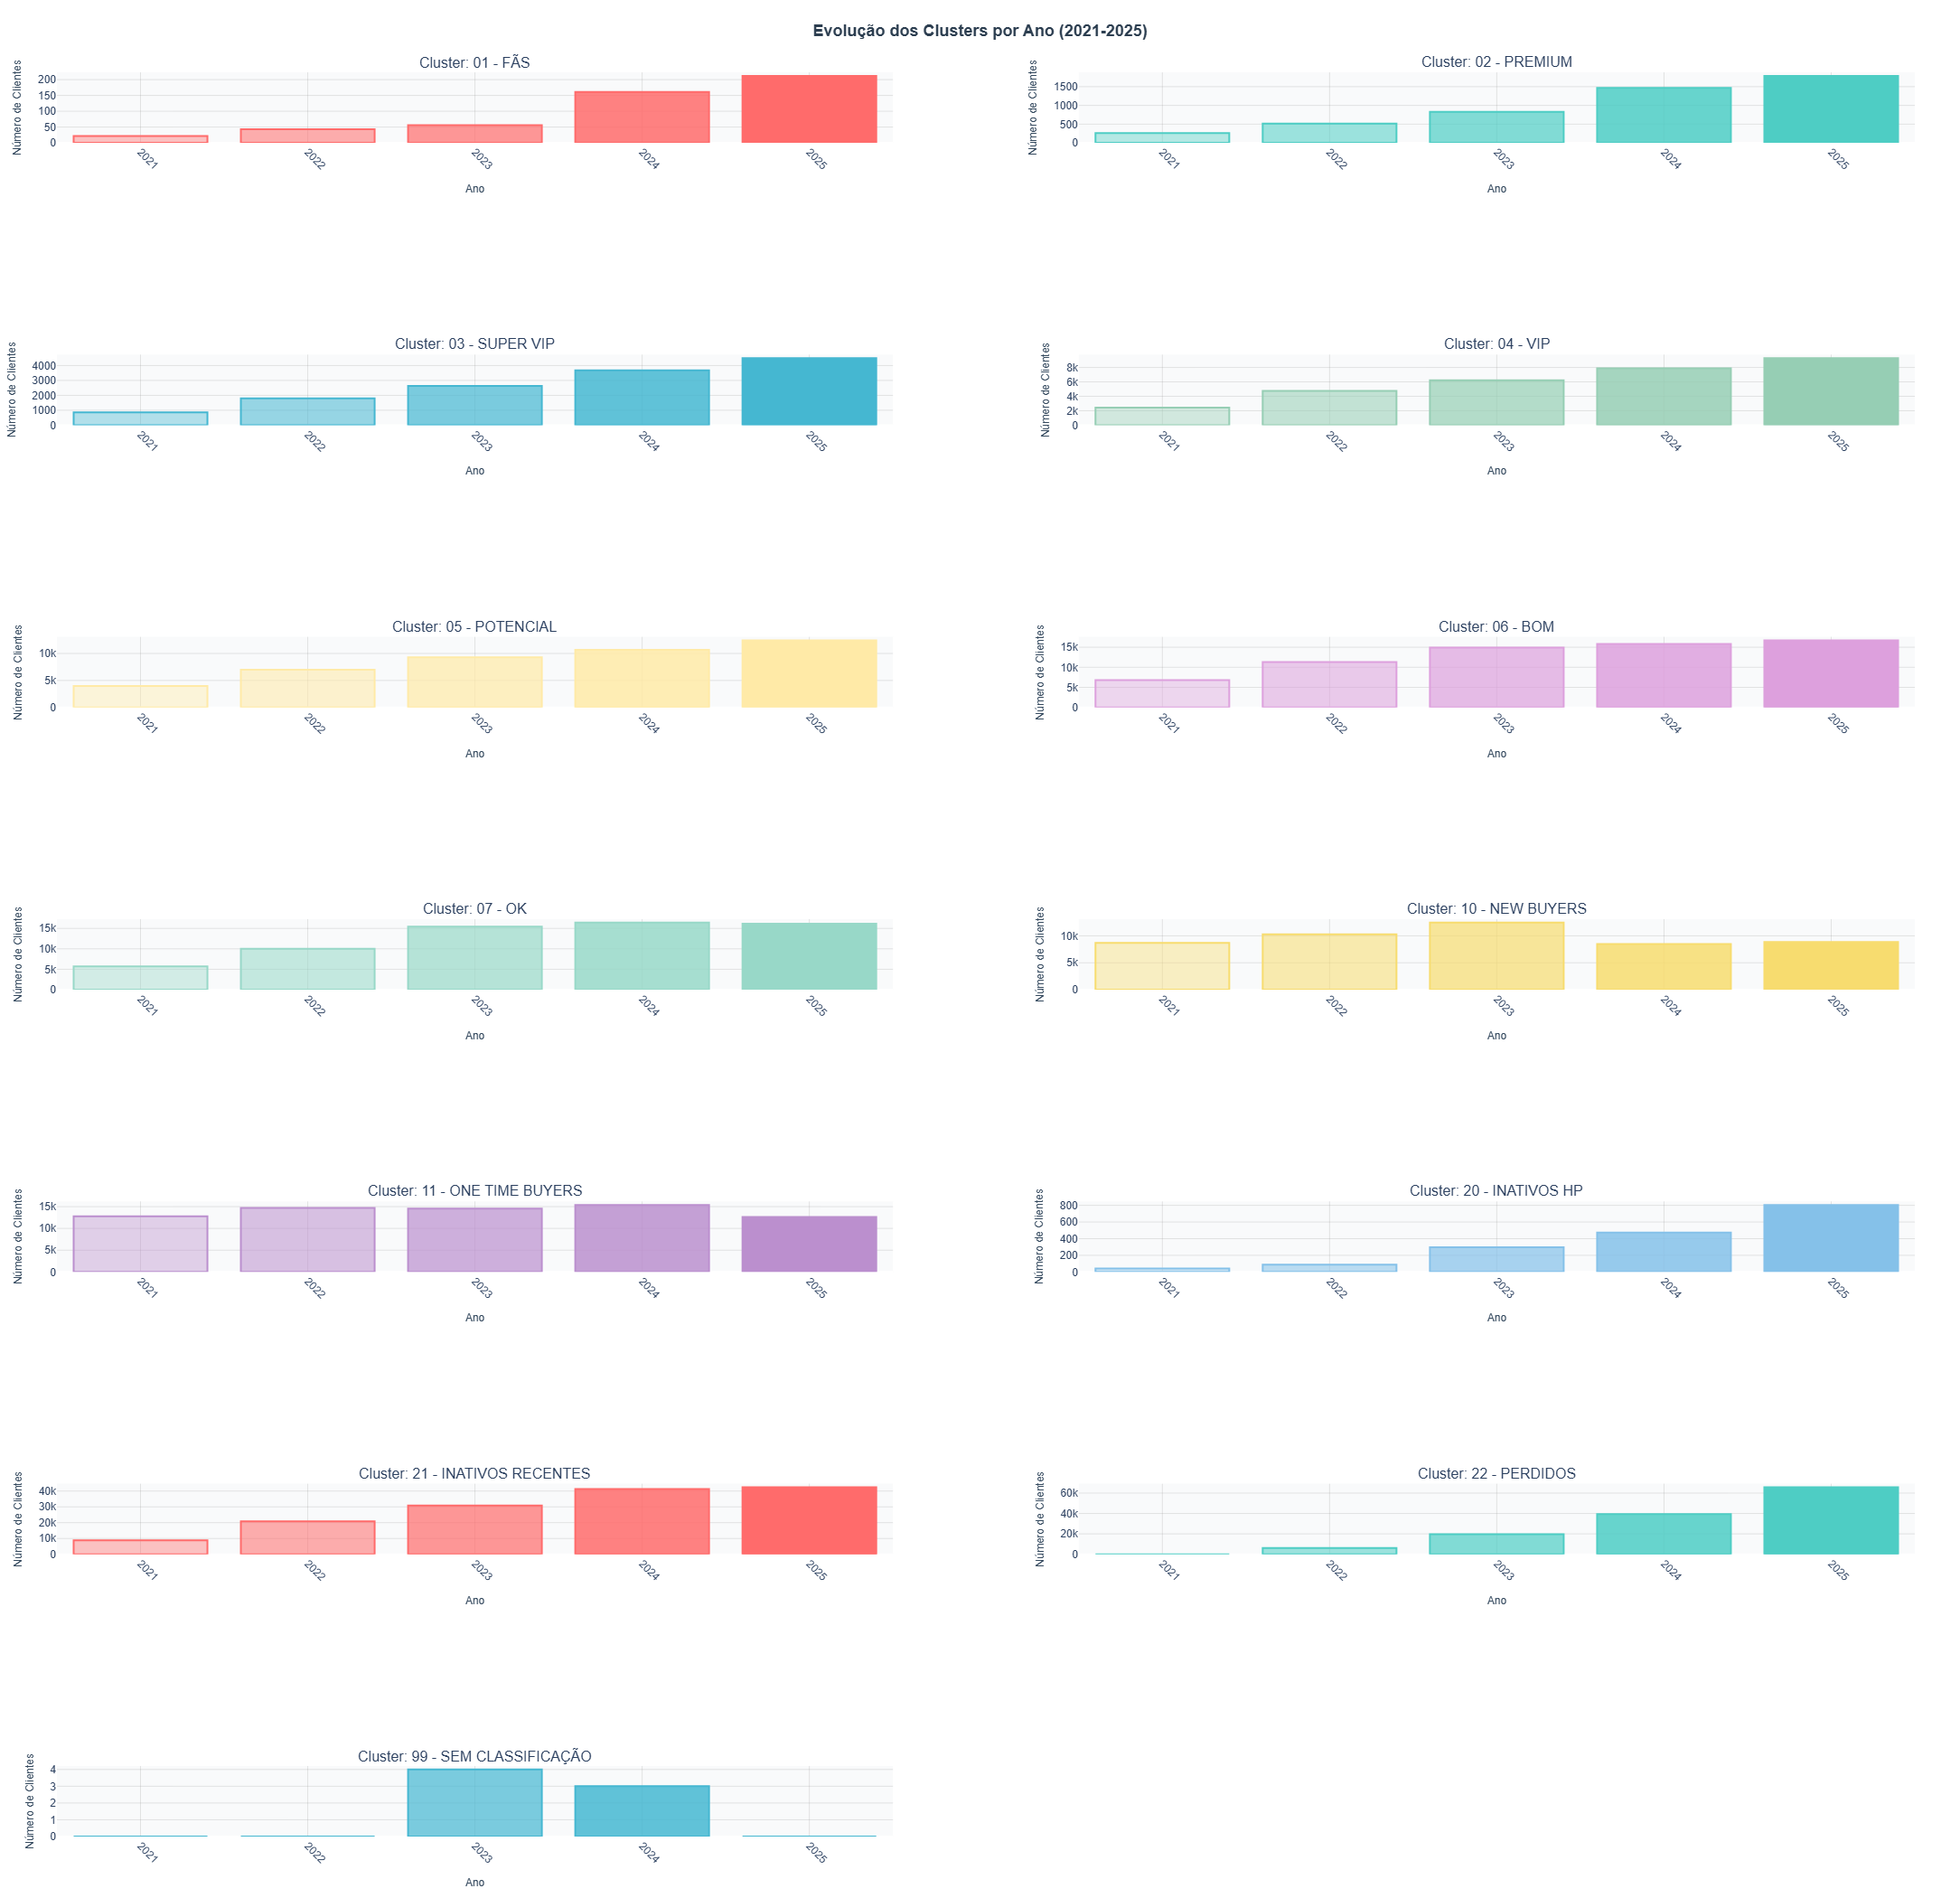

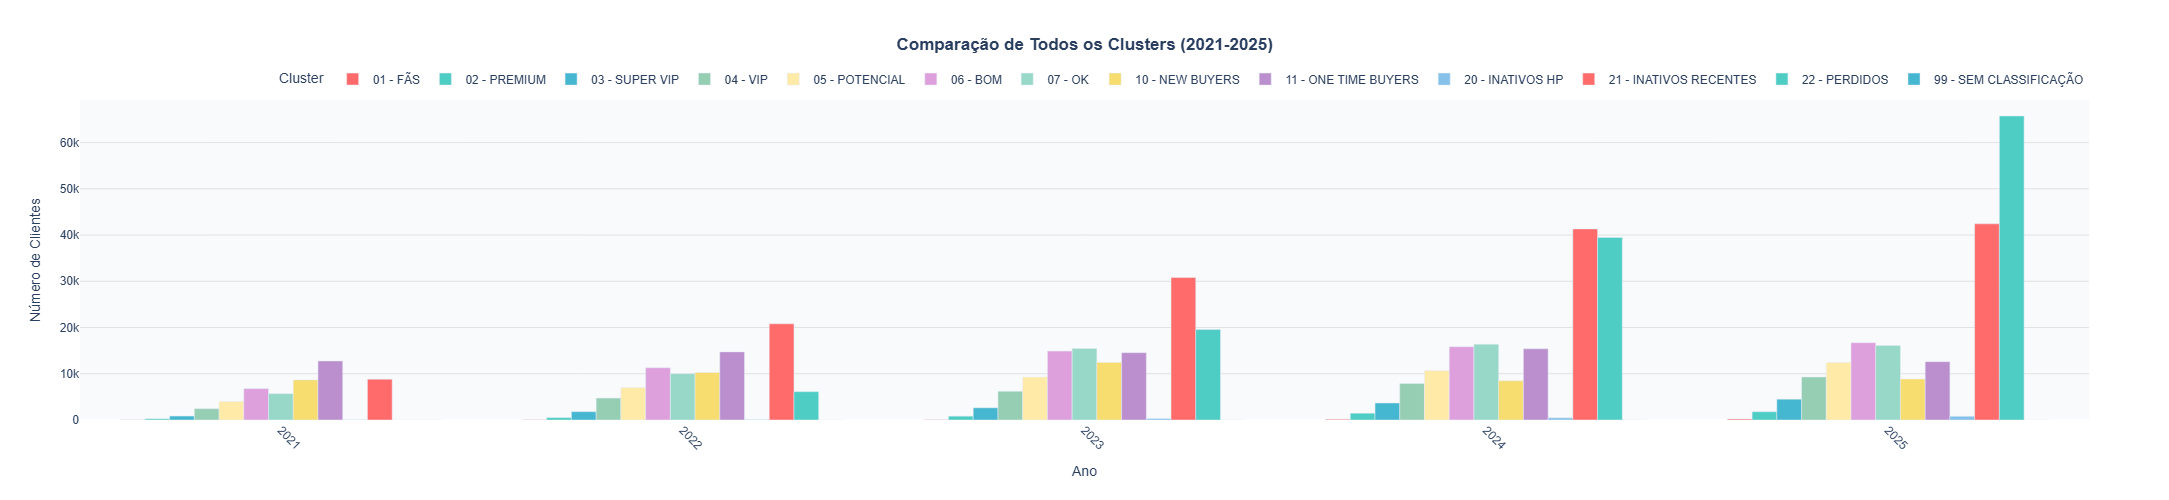



---




# 📊 Análise da Evolução dos Clusters de Clientes (2021–2025)

O gráfico mostra a evolução da base de clientes ao longo de cinco anos, dividida em clusters de comportamento.  
O objetivo é entender o desenvolvimento natural da base dentro do contexto de uma **marca de varejo que busca expandir de forma consistente, sem estratégias desesperadas**.

---

## 🔹 Padrões observados

### 1. Crescimento em **FÃS** e **PREMIUM**
- Expansão contínua desses clusters de maior valor.
- Indica sucesso em **reter e engajar clientes fiéis**.
- Representa um pilar sólido para crescimento sustentável.

### 2. **SUPER VIP** e **VIP** estáveis
- Apresentam crescimento, mas em ritmo mais contido.
- Demonstra **maturidade da base**: apenas parte dos clientes consegue avançar para esses níveis.
- A estabilidade sugere ausência de perdas significativas.

### 3. **Clusters intermediários (POTENCIAL, BOM, OK)**
- Crescimento moderado e consistente.
- Representam a base para alimentar grupos superiores.
- Grande oportunidade em **estratégias de conversão** (cross-sell, incentivos de frequência).

### 4. **Novos compradores (NEW BUYERS, ONE TIME BUYERS)**
- Mantêm relevância, mas sem explosão de crescimento.
- Mostram aquisição de clientes constante e saudável.
- O desafio é aumentar a taxa de retenção para que evoluam para clusters de maior valor.

### 5. **Inativos (HP, Recentes) e Perdidos**
- Tendência de crescimento natural com o envelhecimento da base.
- Risco de perda definitiva se não houver **estratégias de winback**.
- Exigem planos de reengajamento segmentados.

### 6. **Sem classificação**
- Redução observada nesse cluster.
- Indica **melhora na qualidade da informação e abrangência da análise**.

---

## 🔹 Insights estratégicos

- **Fidelização como motor principal**  
  O aumento contínuo de **FÃS** e **PREMIUM** sugere que a marca deve seguir fortalecendo programas de relacionamento e experiências diferenciadas.

- **Conversão do “meio da pirâmide”**  
  Grupos **POTENCIAL, BOM e OK** são a principal base para crescimento.  
  Estratégias de **personalização, cross-sell e estímulo de frequência** podem acelerar a ascensão desses clientes.

- **Aquisição sustentável**  
  A presença estável de **NEW BUYERS** e **ONE TIME BUYERS** mostra que o funil de entrada funciona.  
  O foco deve ser melhorar a retenção inicial.

- **Gestão de inativos**  
  O crescimento dos **INATIVOS** pede atenção.  
  Campanhas de **reengajamento** podem evitar que migrem para o grupo de **PERDIDOS**.

- **Expansão saudável**  
  O comportamento dos clusters mostra que a marca cresce de forma **consistente e sólida**, em linha com a estratégia de expansão não desesperada.

---

## ✅ Conclusão

A marca:
- Está **fortalecendo sua base fiel** (FÃS e PREMIUM).  
- Mantém um **fluxo saudável de novos clientes**.  
- Possui **espaço para conversão** dos grupos intermediários.  
- Precisa conter o **avanço dos inativos**.  

📌 Em resumo: o crescimento observado é **sustentável e consistente**, com equilíbrio entre aquisição, retenção e fidelização.
